## Задача

#### В архиве во вложении данные по выдачам кредитов и платежам: плановым и фактическим. Данные актуальны на 08.12.2022. Проанализируйте характер поведения клиентов с точки зрения просрочки: какая динамика просрочки, наблюдается ли рост или снижение?

## Загрузка и обзор данных

In [2]:
# Импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Импорт таблицы orders и создание датафрейма
df_orders = pd.read_csv('./orders.csv')
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55748 entries, 0 to 55747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    55748 non-null  int64  
 1   created_at  55748 non-null  object 
 2   put_at      55748 non-null  object 
 3   closed_at   46472 non-null  object 
 4   issued_sum  55748 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.1+ MB


In [4]:
df_orders.head()

,order_id,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0


### Данные таблицы orders
* order_id - номер заявки
* created_at - дата создания заявки
* put_at - дата выдачи
* closed_at - дата закрытия
* issued_sum - сумма выдачи

In [5]:
# Импорт таблицы plan и создание датафрейма
df_plan = pd.read_csv('./plan.csv')
df_plan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420282 entries, 0 to 420281
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        420282 non-null  int64  
 1   plan_at         420282 non-null  object 
 2   plan_sum_total  420282 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.6+ MB


In [6]:
df_plan.head()

,order_id,plan_at,plan_sum_total
0,400001732,2022-06-02,5600.0
1,400001732,2022-07-02,9450.0
2,400001732,2022-08-01,12170.0
3,400001732,2022-08-31,14890.0
4,400001732,2022-09-30,17610.0


### Данные таблицы plan
* order_id - номер
* plan_at - дата планового платежа
* plan_sum_total - сумма планового платежа (накопительный итог)

In [7]:
# Импорт таблицы payments и создание датафрейма
df_payments = pd.read_csv('./payments.csv')
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143284 entries, 0 to 143283
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   order_id  143284 non-null  int64  
 1   paid_at   143284 non-null  object 
 2   paid_sum  143284 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.3+ MB


In [35]:
df_payments.head()

,order_id,paid_at,paid_sum
0,400013633,2022-06-02 00:48:13.800,2500.0
1,400018480,2022-06-02 01:52:05.707,1070.0
2,400032001,2022-06-02 04:55:40.307,4200.0
3,400033195,2022-06-02 05:44:23.480,2850.0
4,400039407,2022-06-02 06:53:54.503,10100.0


### Данные таблицы payments
* order_id - номер заявки 
* paid_at - дата фактического платежа
* paid_sum  - сумма фактического платежа (накопительный итог)

## Предобработка данных

#### *Поиск и обработка пропусков*

In [36]:
df_orders.isna().sum()

order_id         0
created_at       0
put_at           0
closed_at     9276
issued_sum       0
dtype: int64

##### Пропущенные значения в таблице не обнаружены, на конец исследуемого периода 9276 незакрытых кредита

In [37]:
df_plan.isna().sum()

order_id          0
plan_at           0
plan_sum_total    0
dtype: int64

In [38]:
df_payments.isna().sum()

order_id    0
paid_at     0
paid_sum    0
dtype: int64

#### *Поиск и обработка дубликатов*

In [39]:
num_doubl = int(df_orders.duplicated().sum())
num_doubl

0

##### Дубликаты не обнаружены

In [40]:
num_doubl_p = int(df_payments.duplicated().sum())
num_doubl_p

5

In [41]:
df_payments[df_payments.duplicated() == True]

,order_id,paid_at,paid_sum
11475,411504997,2022-06-24 17:14:56.997,10100.0
12470,422632789,2022-06-25 23:16:16.000,8080.0
37759,432761640,2022-07-21 12:38:12.000,150.0
38414,420036980,2022-07-21 20:08:58.997,4800.0
139590,456075017,2022-11-22 19:44:08.793,2720.0


##### Обнаружено 5 дубликатов

In [42]:
# Удаление дубликатов из таблицы
df_payments = df_payments.drop_duplicates(['order_id', 'paid_at', 'paid_sum'])
df_payments

,order_id,paid_at,paid_sum
0,400013633,2022-06-02 00:48:13.800,2500.00
1,400018480,2022-06-02 01:52:05.707,1070.00
2,400032001,2022-06-02 04:55:40.307,4200.00
3,400033195,2022-06-02 05:44:23.480,2850.00
4,400039407,2022-06-02 06:53:54.503,10100.00
...,...,...,...
143279,469255350,2022-12-08 12:57:23.747,343.99
143280,452985418,2022-12-08 12:59:40.997,984.83
143281,490824962,2022-12-08 13:09:21.673,866.04
143282,480026135,2022-12-08 13:25:11.987,1193.25


#### *Проверка диапазона значений и изменение типов данных*

In [43]:
df_orders.columns

Index(['order_id', 'created_at', 'put_at', 'closed_at', 'issued_sum'], dtype='object')

In [44]:
# Изменение типа столбцов с датами на datetime64[ns]
df_orders[['created_at', 'put_at', 'closed_at']] = df_orders[['created_at', 'put_at', 'closed_at']].apply(pd.to_datetime, errors='coerce')
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55748 entries, 0 to 55747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_id    55748 non-null  int64         
 1   created_at  55748 non-null  datetime64[ns]
 2   put_at      55748 non-null  datetime64[ns]
 3   closed_at   46472 non-null  datetime64[ns]
 4   issued_sum  55748 non-null  float64       
dtypes: datetime64[ns](3), float64(1), int64(1)
memory usage: 2.1 MB


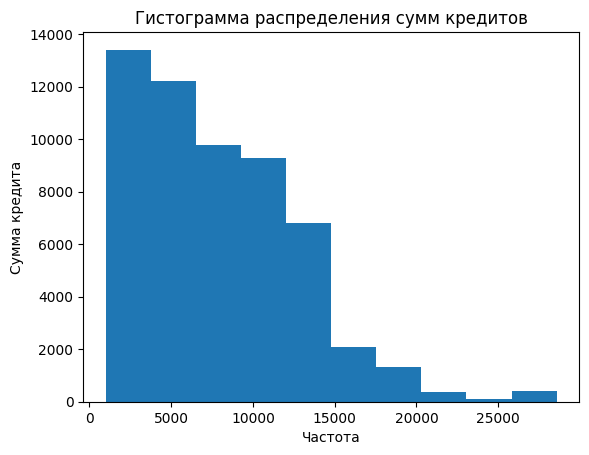

In [45]:
# Гистограмма распределения значений сумм кретидов
plt.hist(df_orders['issued_sum'])
plt.title("Гистограмма распределения сумм кредитов")
plt.xlabel("Частота")
plt.ylabel("Сумма кредита")
plt.show()


In [46]:
# Минимальная сумма кредита
min_sum = float(df_orders['issued_sum'].min())
min_sum

1000.0

In [47]:
# Максимальная сумма кредита
max_sum = float(df_orders['issued_sum'].max())
max_sum

28570.0

##### Диапазоны значений сумм кредитов проверены, экстремально больших значений не обнаружено

In [48]:
df_plan.columns

Index(['order_id', 'plan_at', 'plan_sum_total'], dtype='object')

In [49]:
# Изменение типа столбцов с датами на datetime64[ns]
df_plan['plan_at'] = pd.to_datetime(df_plan['plan_at'])
df_plan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420282 entries, 0 to 420281
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   order_id        420282 non-null  int64         
 1   plan_at         420282 non-null  datetime64[ns]
 2   plan_sum_total  420282 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 9.6 MB


In [50]:
df_payments.columns

Index(['order_id', 'paid_at', 'paid_sum'], dtype='object')

In [51]:
# Изменение типа столбцов с датами на datetime64[ns]
df_payments['paid_at'] = pd.to_datetime(df_payments['paid_at'])
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143279 entries, 0 to 143283
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   order_id  143279 non-null  int64         
 1   paid_at   143279 non-null  datetime64[ns]
 2   paid_sum  143279 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.4 MB


##### Динамику просрочки можно проанализировать через показатель нарушения сроков исполнения обязательств (то есть оплата позже запланированного срока) и показатель нарушения объемов исполнения обязательств


### Анализ динамики нарушения объемов исполнения обязательств по дням 

In [52]:
# Форматирование стобцов с датами для последующей группировки данных по дням без учета времени (час и минуты) платежа
df_payments['paid_at'] = df_payments['paid_at'].dt.floor('d')

In [53]:
# Форматирование стобцов с датами для последующей группировки данных по дням без учета времени (час и минуты) платежа
df_plan['plan_at'] = df_plan['plan_at'].dt.floor('d')

In [54]:
# Пересчет величины плановых платежей в суммы без накопительного итога
df_plan['plan_sum'] = df_plan.groupby('order_id', as_index=False)['plan_sum_total'].diff().fillna(df_plan['plan_sum_total'])
df_plan


,order_id,plan_at,plan_sum_total,plan_sum
0,400001732,2022-06-02,5600.00,5600.00
1,400001732,2022-07-02,9450.00,3850.00
2,400001732,2022-08-01,12170.00,2720.00
3,400001732,2022-08-31,14890.00,2720.00
4,400001732,2022-09-30,17610.00,2720.00
...,...,...,...,...
420277,495177509,2022-12-22,34248.70,2651.33
420278,495177509,2023-01-06,36863.04,2614.34
420279,495177509,2023-01-21,39440.38,2577.34
420280,495177509,2023-02-05,41980.73,2540.35


In [55]:
# Выбор из таблицы заказов, обязательства по которым должны быть выполнены до даты анализа 2022-12-08
df_plan_to_now = df_plan[df_plan['plan_at'] <= '2022-12-08']
df_plan_to_now

,order_id,plan_at,plan_sum_total,plan_sum
0,400001732,2022-06-02,5600.00,5600.00
1,400001732,2022-07-02,9450.00,3850.00
2,400001732,2022-08-01,12170.00,2720.00
3,400001732,2022-08-31,14890.00,2720.00
4,400001732,2022-09-30,17610.00,2720.00
...,...,...,...,...
420272,495177509,2022-10-08,19956.17,3946.17
420273,495177509,2022-10-23,23421.40,3465.23
420274,495177509,2022-11-07,26183.72,2762.32
420275,495177509,2022-11-22,28909.04,2725.32


In [56]:
# Агрегирование данных планируемых выплат по дням из таблице plan в новый датафрейм
df_plan_by_day= df_plan_to_now.groupby('plan_at', as_index=False).agg({'plan_sum' : 'sum'}).rename(columns={'plan_at' : 'date'})
df_plan_by_day

,date,plan_sum
0,2022-06-02,610900.00
1,2022-06-03,652960.00
2,2022-06-04,629490.00
3,2022-06-05,636820.00
4,2022-06-06,858330.00
...,...,...
185,2022-12-04,1696468.79
186,2022-12-05,1755510.35
187,2022-12-06,1767811.32
188,2022-12-07,1641300.02


In [57]:
# Агрегирование данных фактических выплат по дням из таблице payments в новый датафрейм
df_payments_by_day = df_payments.groupby('paid_at', as_index=False).agg({'paid_sum' : 'sum'}).rename(columns={'paid_at' : 'date'})
df_payments_by_day

,date,paid_sum
0,2022-06-02,557960.00
1,2022-06-03,795085.00
2,2022-06-04,782820.00
3,2022-06-05,844265.00
4,2022-06-06,1200220.53
...,...,...
185,2022-12-04,294529.92
186,2022-12-05,487246.21
187,2022-12-06,530829.60
188,2022-12-07,339686.40


In [58]:
# Объединение агрегированных данных с плановыми и фактическими выплатами по дням в новый датафрейм
dif_by_day = df_payments_by_day.merge(df_plan_by_day, how='outer', on='date')
dif_by_day

,date,paid_sum,plan_sum
0,2022-06-02,557960.00,610900.00
1,2022-06-03,795085.00,652960.00
2,2022-06-04,782820.00,629490.00
3,2022-06-05,844265.00,636820.00
4,2022-06-06,1200220.53,858330.00
...,...,...,...
185,2022-12-04,294529.92,1696468.79
186,2022-12-05,487246.21,1755510.35
187,2022-12-06,530829.60,1767811.32
188,2022-12-07,339686.40,1641300.02


In [59]:
# Определение сумм просроченных выплат по дням, при отсутствии просрочек значению суммы присваивается 0.
dif_by_day['dif'] = dif_by_day['plan_sum'] - dif_by_day['paid_sum']
dif_by_day['dif_duty'] = dif_by_day.apply(lambda x: 0 if x["dif"]<=0 else x['dif'], axis=1)
dif_by_day


,date,paid_sum,plan_sum,dif,dif_duty
0,2022-06-02,557960.00,610900.00,52940.00,52940.00
1,2022-06-03,795085.00,652960.00,-142125.00,0.00
2,2022-06-04,782820.00,629490.00,-153330.00,0.00
3,2022-06-05,844265.00,636820.00,-207445.00,0.00
4,2022-06-06,1200220.53,858330.00,-341890.53,0.00
...,...,...,...,...,...
185,2022-12-04,294529.92,1696468.79,1401938.87,1401938.87
186,2022-12-05,487246.21,1755510.35,1268264.14,1268264.14
187,2022-12-06,530829.60,1767811.32,1236981.72,1236981.72
188,2022-12-07,339686.40,1641300.02,1301613.62,1301613.62


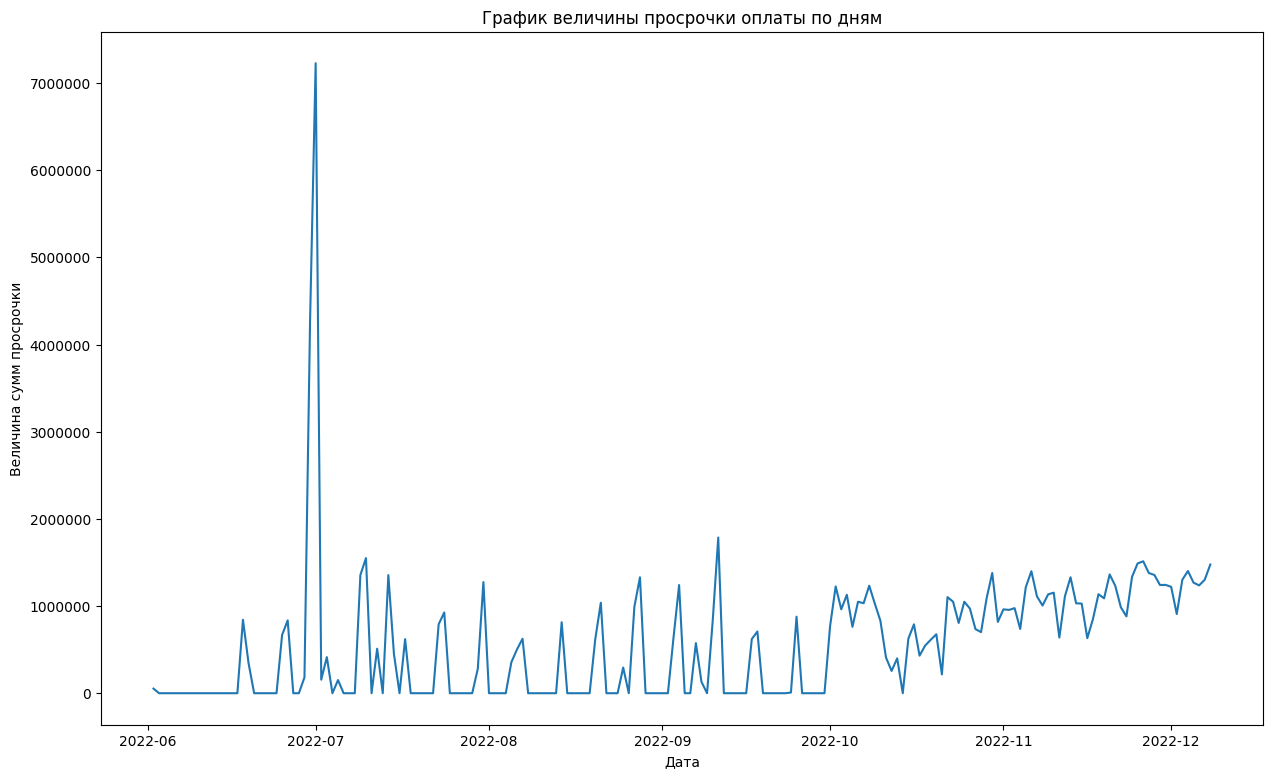

In [76]:
# Построим график величины просрочки оплаты по дням
plt.figure(figsize=(15, 9))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.plot(dif_by_day['date'], dif_by_day['dif_duty'])
plt.title('График величины просрочки оплаты по дням')
plt.xlabel('Дата')
plt.ylabel('Величина сумм просрочки')
plt.show()


In [69]:
# Пересчет сумм просрочки через скользящее среднее, чтобы отразить на графике тенденцию просрочки по неделям
dif_by_day['dif_roll'] = dif_by_day['dif_duty'].rolling(window=7).mean() 

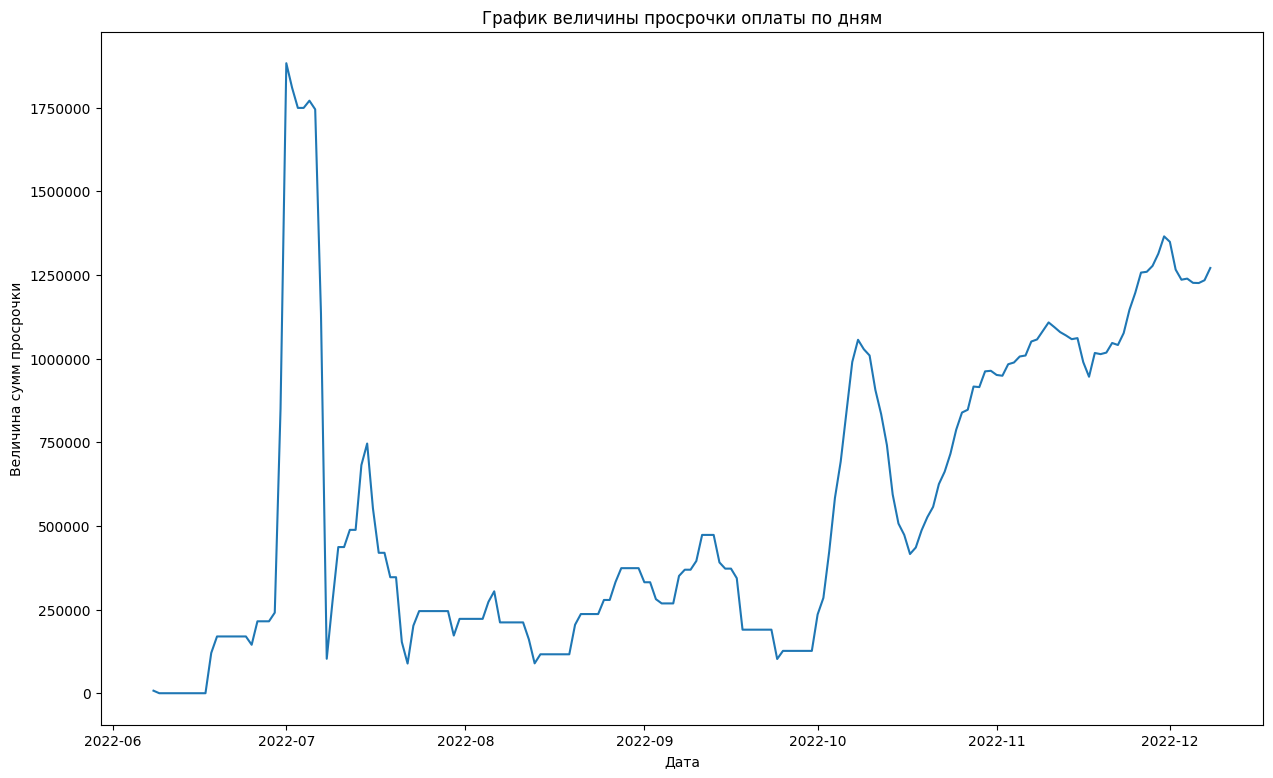

In [77]:
# Построим график сумм просрочки через скользящее среднее
plt.figure(figsize=(15, 9))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.plot(dif_by_day['date'], dif_by_day['dif_roll'])
plt.title('График величины просрочки оплаты по дням')
plt.xlabel('Дата')
plt.ylabel('Величина сумм просрочки')
plt.show()

### По графику делаем вывод, что за рассматриваемый период к концу года наблюдается рост величины просрочки